# Path planning

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy.linalg as linalg

Just a bunch of helper methods

In [3]:
def circle(x, y, r, n=100):
    t = linspace(0, 2*pi, n)
    return r*cos(t)+x, r*sin(t)+y

def phi(x):
    q = np.exp(x)
    return 1/(1+q)

def d_phi(x):
    q = 1/(1+np.exp(x))
    return -q*(1-q)

In [16]:
vec_phi = np.vectorize(phi)
vec_d_phi = np.vectorize(d_phi)

def compute_loss(curr_pos, circ_mat, circ_rad, C):
    all_dist = C*(linalg.norm(circ_mat - curr_pos[:,newaxis], axis=0)**2/circ_rad - 1)
    return np.sum(phi(all_dist))
    
def loss(pos_mat, circ_mat, circ_rad, C):
    return np.sum(np.apply_along_axis(lambda x: compute_loss(x, circ_mat, circ_rad, C), 0, pos_mat))

def compute_dloss(curr_pos, circ_mat, circ_rad, C):
    dif_mat = curr_pos[:,newaxis] - circ_mat
    all_dist = C*(linalg.norm(dif_mat, axis=0)**2/circ_rad - 1)
    return 2*C*np.sum(d_phi(all_dist)*dif_mat/circ_rad, axis=1)

def dloss(pos_mat, circ_mat, circ_rad, C):
    return np.apply_along_axis(lambda x: compute_dloss(x, circ_mat, circ_rad, C), 0, pos_mat)

def complete_dloss(pos_mat, circ_mat, circ_rad, C, K):
    dloss_obstacles = dloss(pos_mat, circ_mat, circ_rad, C)[:,1:-1]
    diff_mat = -pos_mat[:,:-2] + 2*pos_mat[:,1:-1] - pos_mat[:,2:]
    zeros_mat = np.zeros(2)[:,newaxis]
    return np.c_[zeros_mat, dloss_obstacles + K*diff_mat, zeros_mat]

def complete_loss(pos_mat, circ_mat, circ_rad, C, K):
    loss_obstacles = loss(pos_mat, circ_mat, circ_rad, C)
    loss_diff = sum(linalg.norm(pos_mat[:,1:] - pos_mat[:,:-1], axis=0))
    return loss_obstacles + K*loss_diff


Plot the initial path guess

In [24]:
def plot_path(points, circles, radii, plot_title=''):
    plot(points[0,:], points[1,:], '-')
    for idx in range(len(radii)):
        curr_circle = circle(circles[0, idx], circles[1, idx], radii[idx])
        plot(curr_circle[0], curr_circle[1], 'r')
        
    gca().set_aspect('equal')
    title(plot_title)
    #xlim(-1, 1)
    #ylim(-.7, .7)

In [28]:
N_points = 100
points = np.zeros((2, N_points)) # the initial set of points
points[0,:] = np.linspace(-1, 1, N_points)

circ_pos = np.array([0, 0.1])[:,newaxis]
print(circ_pos)
circ_radius2 = np.array([(1/2.)**2])
print(circ_radius2)

[[ 0. ]
 [ 0.1]]
[ 0.25]


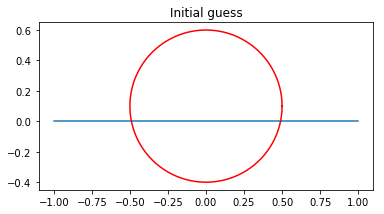

In [29]:
plot_path(points, circ_pos, sqrt(circ_radius2), 'Initial guess')

The idea here is to use the classical momentum technique; e.g. consider some 'velocity' vector $v_t$, where $\eta > 0$ is the learning rate, and where $0 < \mu < 1$ is the momentum coefficient, then we have the following scheme, for $\theta_t$ being the argument at iteration $t$, which we're minimizing over:

$$
\begin{align}
v_t &=& \mu v_{t-1} - \eta \nabla f(\theta_{t-1})\\
\theta_t &=& \theta_{t-1} + v_t
\end{align}
$$

Running this new iterative scheme is much faster than just vanilla gradient descent, though it doesn't fully optimize the function (e.g. compare the `spring_backtracking_momentum` to `spring_step_backtracking`), so it might be worth doing a second-pass using just a simple gradient descent with line search to complete the optimization. There's also this question of whether this would even be necessary or if we just want to do 'good enough' for our purposes.

Note also that we send $C\to\infty$ at the same time that we optimize the objective: this is done to save time. E.g. while we could optimize first over each $C$ and then rework the problem after each $C$ has converged (which may be a possibility to evaluate); in general, the intial steps will be quite crappy, and we don't really care about convergence for small $C$ (soft-wall constraints), but rather we only really want the solution to the problem for larger $C$; this seems like a reasonable tradeoff, even though we may not be guaranteed to reach a local optimum point here, anyways.

In [30]:
MAX_ITER = 1000
INIT_STEP_SIZE = 1e-3
MIN_STEP = 1e-2
RESET_STEP_SIZE = 1e-7
COOLING_SCHEDULE = 1.0001
FAST_COOLING_SCHEDULE = 1.1
INIT_CONSTRAINT_HARDNESS = 1
INIT_SPRING_HARDNESS = 20
MAX_TIME_INCREASE = 10
MOMENTUM_CHANGE = .2

curr_pos = copy(points * 100)
constraint_hardness = INIT_CONSTRAINT_HARDNESS

circ_pos = array([[-.5, .1], [-.15, -.5], [.25, .25], [.5, -.05], [-.25, .5]]).T * 100
circ_radius2 = (array([.2, .4, .25, .2, .25]) * 100) **2

print(circ_pos)
print(circ_radius2)

count = 0
curr_step = INIT_STEP_SIZE
prev_loss = float('inf')
momentum = .99

prev_velocity = np.zeros(curr_pos.shape)
curr_velocity = copy(prev_velocity)

times_increased = 0
converged = False

for i in range(MAX_ITER+1):
    while True:
        # Accelerated gradient (e.g. with momentum)
        curr_velocity = momentum * prev_velocity - curr_step*complete_dloss(curr_pos, circ_pos, circ_radius2, constraint_hardness, INIT_SPRING_HARDNESS)
        proposed_pos = curr_pos + curr_velocity
        curr_loss = complete_loss(proposed_pos, circ_pos, circ_radius2, constraint_hardness, INIT_SPRING_HARDNESS)
        
        # Ensure decrease
        if curr_loss < prev_loss:
            curr_pos = proposed_pos
            prev_velocity = curr_velocity
            prev_loss = curr_loss
            curr_step *= 2
            times_increased = 0
            break
        # Otherwise, decrease the step size
        else:
            curr_step *= .8
        if curr_step < MIN_STEP:
            if times_increased > MAX_TIME_INCREASE:
                print('Cooling schedule is finished. Converged to final result.')
                converged = True
                break
            # Once the cooling step converges, increase the constraint hardness such that the optimization
            # Can finish
            print('Converged in cooling step; increasing schedule'
                  '(C={}) and resetting velocity'.format(constraint_hardness))
            prev_velocity = np.zeros(prev_velocity.shape)
            constraint_hardness *= FAST_COOLING_SCHEDULE
            
            curr_step = RESET_STEP_SIZE;
            times_increased += 1

    if converged:
        break
    constraint_hardness *= COOLING_SCHEDULE
    
    
    if i%10==0:
        plot_path(curr_pos, circ_pos, sqrt(circ_radius2), 'Iteration: {}'.format(i))
        savefig('images/iter{:02d}.png'.format(count))
        close()
        count += 1
        print('On iteration {}'.format(i))
        print('Current step size : {}'.format(curr_step))
        
       

[[-50. -15.  25.  50. -25.]
 [ 10. -50.  25.  -5.  50.]]
[  400.  1600.   625.   400.   625.]
On iteration 0
Current step size : 0.002
On iteration 10
Current step size : 1.31072
On iteration 20
Current step size : 0.09134385233318165
Converged in cooling step; increasing schedule(C=1.002603252601495) and resetting velocity
On iteration 30
Current step size : 3.2e-06
On iteration 40
Current step size : 0.0032768
Converged in cooling step; increasing schedule(C=1.1047399465886845) and resetting velocity
On iteration 50
Current step size : 2.56e-05
On iteration 60
Current step size : 0.0262144
Converged in cooling step; increasing schedule(C=1.217403186611115) and resetting velocity
On iteration 70
Current step size : 0.0001024
Converged in cooling step; increasing schedule(C=1.3415560135644309) and resetting velocity
On iteration 80
Current step size : 4e-07
On iteration 90
Current step size : 0.0004096
Converged in cooling step; increasing schedule(C=1.4783701548711343) and resetting v

/Users/ischeinfeld/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: overflow encountered in exp
/Users/ischeinfeld/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: overflow encountered in exp



On iteration 630
Current step size : 0.0016384
Converged in cooling step; increasing schedule(C=13.972228346045322) and resetting velocity
On iteration 640
Current step size : 1.6e-06
On iteration 650
Current step size : 0.0016384
Converged in cooling step; increasing schedule(C=15.401759324427271) and resetting velocity
On iteration 660
Current step size : 8e-07
On iteration 670
Current step size : 0.0008192
On iteration 680
Current step size : 0.2199023255552001
Converged in cooling step; increasing schedule(C=16.98094460107617) and resetting velocity
On iteration 690
Current step size : 0.0001024
On iteration 700
Current step size : 0.1048576
Converged in cooling step; increasing schedule(C=18.72204814209046) and resetting velocity
On iteration 710
Current step size : 1.28e-05
Converged in cooling step; increasing schedule(C=20.625165969072754) and resetting velocity
On iteration 720
Current step size : 4e-07
On iteration 730
Current step size : 0.0004096
On iteration 740
Current s